# Translation Invariant Artificial Neural Network

An important performance issue of an Artificial Neural Network (ANN) is to consider whether its predictions remain unchanged, or invariant, under one or more transformations of the input data.

In the previous notebook we have seen that the Multi-Layer Perceptron (MLP), which is a fully connected feed-forward neural network, is not invariant to translation of the images. We needed to augment the training data by adding shifted images and then to train the MLP to make it translation invariant.

In this notebook we present an alternative approach for encouraging an adaptive model to exhibit the required invariances.

The alternative approach for invariance is to build the invariance properties into the structure of a neural network. One way to achieve this is through the use of local receptive fields and shared weights. This is the basis for the **convolutional neural network (CNN)** which has been widely applied to image data.



## Convolutional Neural Network (CNN)

We will build a CNN and show that it is invariant to **translation of images**. The discussion on the CNN model and choice of architecture is for another notebook. In this notebook we use a simple architecture to build the CNN.

We will use an augmented test dataset to evaluate the performance of the CNN. The augmented test dataset contains images that are created by shifting the original images along x-y axes.

We will use Keras to build the CNN. Keras is a high-level Deep Learning API that allows to easily build, train, evaluate, and execute all sorts of neural networks. Its documentation (or specification) is available at https://keras.io/. 

Keras can be used both with a CPU as well as a GPU. For this notebook, we use Keras configured with Tensorflow on a CPU machine. For the simple MNIST dataset a CPU configuration is enough. 

In [1]:
import warnings
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Data Matrix (X) and the Label Vector (y)

We will use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

There are 70,000 images. Each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has 784 features.

First load the data from a local folder (obtain it from Canvas) or load it directly from cloud using Scikit-Learn. We could also used Keras to load the MNIST data.

In [2]:
# Load the data from the local folder "data"
mnist = loadmat('/Users/hasan/datasets/MNIST/mnist-original.mat')

#Create the data Matrix X and the target vector y
X = mnist["data"].T.astype('float64')
y = mnist["label"][0].astype('int64')

# Load data using Scikit-Learn
# mnist = fetch_openml('mnist_784', cache=False)

# X = mnist["data"].astype('float64')
# y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Data Preprocessing

Before we train the CNN model, we need to do some data preprocessing.

- Re-scaling the images data to a values between 0.0 and 1.0 (i.e. each pixel should have value between (0.0 and 1.0].

- Reshaping the images data to a tensor of shape (num_samples, image_height, image_width, num_channels). For our 28x28 grayscale images, this would be (num_samples, 28, 28, 1).

- One-hot-encode the labels

## Scale the Data

In [3]:
X /= 255.0

X.min(), X.max()

(0.0, 1.0)

## Create Train, Validation and Test Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train & validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## Reshaping the Images Data


Reshape the images data to a tensor of shape (num_samples, image_height, image_width, num_channels). 

For our 28x28 grayscale images, this would be (num_samples, 28, 28, 1).

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print("X_train: ", X_train.shape)
print("X_valid: ", X_valid.shape)
print("X_test: ", X_test.shape)


image_height = 28  
image_width = 28
num_channels = 1  

X_train:  (44800, 28, 28, 1)
X_valid:  (11200, 28, 28, 1)
X_test:  (14000, 28, 28, 1)


## One-hot-encode the Labels

In [6]:
num_classes = 10

y_train_cat = to_categorical(y_train,num_classes)
y_valid_cat = to_categorical(y_valid,num_classes)
y_test_cat = to_categorical(y_test,num_classes)

## Build a CNN

We build a CNN with the following architecture, using Keras’ Sequential API:

- 3 Conv2D layers with 32, 64 and 64 filters each, using the relu activation, kernel_size=(3,3) and padding=’same’

- Each Conv2D layer is followed immediately by a MaxPooling2D layer with a pool_size=(2,2)

- We follow this with a Dense layer with 512 nodes and relu activation

- Finally, our output layer is a Dense layer with 10 nodes (corresponding to the 10 output classes) and softmax activation function

We use softmax for multi-class classification.

We compile the model with **categorical_crossentropy loss** and the **adam** optimizer.

In [7]:
def build_model():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

## Model Summary

The model’s summary() method displays all the model’s layers, including each layer’s name (which is automatically generated), its output shape (None means the batch size can be anything), and its number of parameters. 

The summary ends with the total number of parameters, including trainable and non-trainable parameters.

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

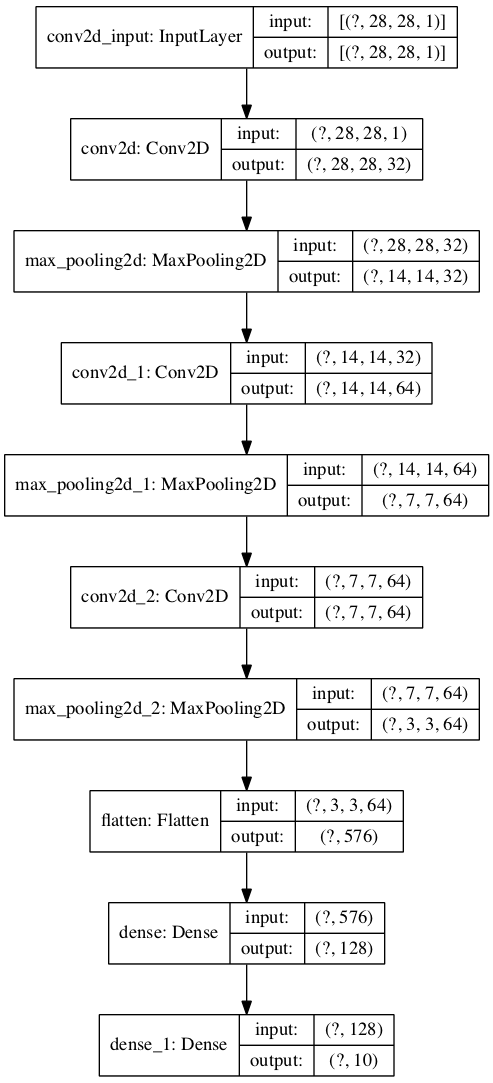

In [9]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

## Training CNN

We train the model on the training set and the cross-validation set that we created earlier. 

Training is run for 15 epochs, with a batch size of 64. 

In [10]:
%%time

results = model.fit(X_train, y_train_cat, 
                    epochs=15, batch_size=64,
                    validation_data=(X_valid, y_valid_cat))

Train on 44800 samples, validate on 11200 samples
Epoch 1/15
44800/44800 [==============================] - 31s 700us/sample - loss: 0.1998 - accuracy: 0.9383 - val_loss: 0.0595 - val_accuracy: 0.9822
Epoch 2/15
44800/44800 [==============================] - 26s 588us/sample - loss: 0.0527 - accuracy: 0.9829 - val_loss: 0.0470 - val_accuracy: 0.9848
Epoch 3/15
44800/44800 [==============================] - 27s 593us/sample - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.0418 - val_accuracy: 0.9864
Epoch 4/15
44800/44800 [==============================] - 26s 572us/sample - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0395 - val_accuracy: 0.9887
Epoch 5/15
44800/44800 [==============================] - 26s 573us/sample - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0342 - val_accuracy: 0.9898
Epoch 6/15
44800/44800 [==============================] - 26s 570us/sample - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.0306 - val_accuracy: 0.9911
Epoch 7/15
44800/44800 [====================

In [11]:
results.history

{'loss': [0.19978608060827746,
  0.05271462653730331,
  0.036081658694893125,
  0.028126703837770037,
  0.021998253066766275,
  0.019946955978126166,
  0.01383375279462468,
  0.014491395280082153,
  0.010791706953542805,
  0.009855446643724853,
  0.0107646447612238,
  0.007528981363097305,
  0.006033855979513549,
  0.007053416685103165,
  0.007907201637449686],
 'accuracy': [0.93825895,
  0.98287946,
  0.98837054,
  0.9909152,
  0.99319196,
  0.9931473,
  0.9952232,
  0.9949107,
  0.99620533,
  0.9964732,
  0.9960491,
  0.9971875,
  0.99785715,
  0.99787945,
  0.9974107],
 'val_loss': [0.05947733117799674,
  0.04696906943539424,
  0.04183486032632312,
  0.039471086324192585,
  0.034234125041735494,
  0.030647005247717192,
  0.043941376606401586,
  0.03145350021942119,
  0.04304395219485741,
  0.031506131763557536,
  0.04439737807618387,
  0.03460278875934559,
  0.037046858401330866,
  0.03805528263531285,
  0.03451577110987533],
 'val_accuracy': [0.98223215,
  0.98482144,
  0.98642856,

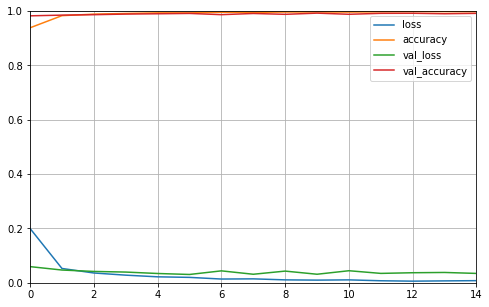

In [12]:
pd.DataFrame(results.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [13]:
test_loss, test_accuracy = \
  model.evaluate(X_test, y_test_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

14000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 0.0457 accuracy: 0.9900


## Evaluate the CNN on the Test Data

In [14]:
y_test_predicted= model.predict_classes(X_test)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.99

Test Confusion Matrix:
[[1304    0    3    0    0    1    3    0    1    0]
 [   0 1594    3    1    1    1    0    3    0    1]
 [   0    2 1341    2    1    0    0    1    1    0]
 [   0    1    5 1415    0    4    0    0    1    1]
 [   0    0    1    0 1355    0    0    1    0    5]
 [   0    0    3    8    0 1258    4    0    6    1]
 [   2    0    0    0    1    3 1391    0    0    0]
 [   0    0    5    1    4    0    0 1448    0    3]
 [   0    2    2    4    0    2    0    1 1379    0]
 [   2    2    2    4   16    3    0    8    7 1375]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1312
           1       1.00      0.99      0.99      1604
           2       0.98      0.99      0.99      1348
           3       0.99      0.99      0.99      1427
           4       0.98      0.99      0.99      1362
           5       0.99      0.98      0.99      1280
           6       0

## Load the Augmented Test Data (Images are Shifted)

Now we will use an augmented test dataset to evaluate the performance of the CNN. 

The augmented test dataset contains images that are created by shifting the original images along x-y axes.

In [15]:
array = loadmat('/Users/hasan/datasets/MNIST/Test_Data_Shifted.mat')

#Create the data Matrix X and the target vector y
X_test_augmented = array["X_test"].astype('float64')
y_test_augmented = array["y_test"][0].astype('int64')

## Visualize the Augmented Test Data

We will see that some images are shifted.

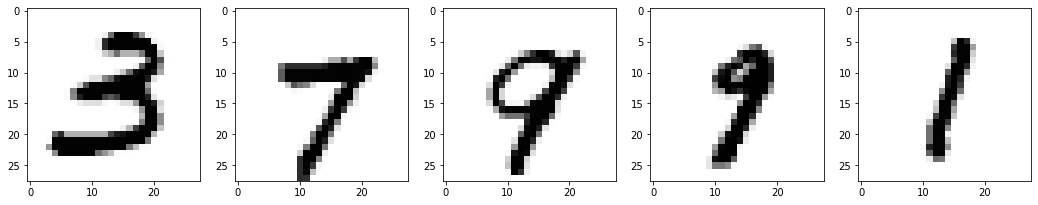

In [16]:
image1 = X_test_augmented[100]
image2 = X_test_augmented[201]
image3 = X_test_augmented[302]
image4 = X_test_augmented[403]
image5 = X_test_augmented[504]

plt.figure(figsize=(18,6))

plt.subplot(151)
plt.imshow(image1.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)

plt.imshow(image2.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)

plt.imshow(image3.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)

plt.imshow(image4.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)

plt.imshow(image5.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

## Preprocess the Augmented Test Data

In [17]:
# Scale
X_test_augmented /= 255.0


# Reshape
X_test_augmented = X_test_augmented.reshape(X_test_augmented.shape[0], 28, 28, 1)


# One-hot encode the labels
y_test_augmented_cat = to_categorical(y_test_augmented,num_classes)

## Evaluate the CNN Model on Augmented Test Data

In [18]:
y_test_predicted_augmented = model.predict_classes(X_test_augmented)

test_accuracy_augmented = np.mean(y_test_predicted_augmented == y_test_augmented)
print("\nTest Accuracy (Augmented): ", test_accuracy_augmented)

print("\nTest Confusion Matrix (Augmented):")
print(confusion_matrix(y_test_augmented, y_test_predicted_augmented))

print("\nClassification Report (Augmented):")
print(classification_report(y_test_augmented, y_test_predicted_augmented))


Test Accuracy (Augmented):  0.9305714285714286

Test Confusion Matrix (Augmented):
[[5931   32  190    8   56   15  194   10   69   55]
 [   3 7757   35    6   35    4  135   35    4    6]
 [   1   29 6529   59   32   14   16   46    6    8]
 [   2   11  214 6866    2   22    1    6    6    5]
 [  36   73   18    4 6554   24   21   43   12   25]
 [   7    4  125  113    3 5998   51    3   62   34]
 [  52   88   15    1   54   18 6704    0   27   26]
 [   7   32  297   34  112   35    1 6777    1    9]
 [  28   37  130  204   13  120  155   19 6212   32]
 [ 116   28   95  109  334  120   47  219  215 5812]]

Classification Report (Augmented):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6560
           1       0.96      0.97      0.96      8020
           2       0.85      0.97      0.91      6740
           3       0.93      0.96      0.94      7135
           4       0.91      0.96      0.94      6810
           5       0.94 

## Observation

We see that the accuracy of the augmented test data 93%. It indicates that the CNN model has some degree of translation invariance in it. 

Previously, in case of Multi-Layer Perceptron (MLP), we needed to augment the training data by adding shifted images and then to train the MLP to make it translation invariant.

The CNN model is powerful enough to understand the local structure of the images and is inherently translation invariant.